In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from IPython.display import set_matplotlib_formats
from pathlib import Path
from matplotlib import colors

import h3
import shapely
import geopandas as gpd
import contextily as ctx
from shapely.geometry import shapely
import json
from h3 import h3
from shapely.geometry import shape
import folium
from tqdm import tqdm

import energizer # own package

from energizer.io import *
from energizer.vis import *


pd.set_option('display.max_columns', None)
%matplotlib inline

# Import spatial data

In [3]:
trip_data_7 = energizer.io.read_all_files(filetype='parquet', hexagons=True, resolution='hex_res_7')
print('read in trip_data_7')
trip_data_8 = energizer.io.read_all_files(filetype='parquet', hexagons=True, resolution='hex_res_8')
print('read in trip_data_8')
trip_data_9 = energizer.io.read_all_files(filetype='parquet', hexagons=True, resolution='hex_res_9')
print('read in trip_data_9')
trip_data_8.head(3)

read in trip_data_7
read in trip_data_8
read in trip_data_9


trip_id  taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  \
0        0        0  2013-01-01 00:15:00 2013-01-01 00:30:00         480.0   
1        1        1  2013-01-01 00:15:00 2013-01-01 00:30:00        1080.0   
2        2        2  2013-01-01 00:15:00 2013-01-01 00:15:00         180.0   

   trip_miles   fare  tips  tolls  extras  trip_total payment_type  \
0         3.8  10.65   2.0    0.0     1.0       13.65  Credit Card   
1         2.6  12.85   0.0    0.0     0.0       12.85         Cash   
2         0.1   4.25   0.0    0.0     1.5        5.75         Cash   

   pickup_census_tract  pickup_community_area  pickup_centroid_latitude  \
0         1.703108e+10                    8.0                 41.892042   
1         1.703124e+10                   24.0                 41.892658   
2         1.703108e+10                    8.0                 41.892073   

   pickup_centroid_longitude  \
0                 -87.631864   
1                 -87.652534   
2                 -87.628874   

                            pickup_centroid_location  dropoff_community_area  \
0  {'coordinates': [-87.6318639497, 41.8920421365...                     7.0   
1  {'coordinates': [-87.6525344838, 41.8926581076...                     6.0   
2  {'coordinates': [-87.6288741572, 41.8920726347...                    32.0   

   dropoff_centroid_latitude  dropoff_centroid_longitude  \
0                  41.921877                  -87.664078   
1                  41.942585                  -87.656644   
2                  41.880994                  -87.632746   

                           dropoff_centroid_location  dropoff_census_tract  \
0  {'coordinates': [-87.6640782395, 41.9218774613...          1.703183e+10   
1  {'coordinates': [-87.6566440918, 41.9425851797...          1.703106e+10   
2  {'coordinates': [-87.6327464887, 41.8809944707...          1.703184e+10   

                     company  humidity  temperature    hex_ID_pickup  \
0                       None      64.0        -0.19  882664c1e7fffff   
1  Dispatch Taxi Affiliation      64.0        -0.19  882664cad1fffff   
2  Dispatch Taxi Affiliation      64.0        -0.19  882664c1e1fffff   

    hex_ID_dropoff  
0  882664c123fffff  
1  882664c163fffff  
2  882664c1a9fffff

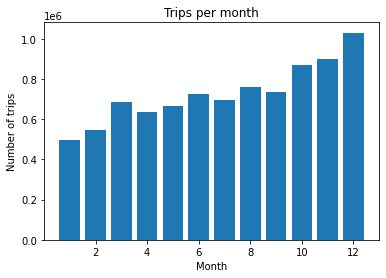

In [5]:
# Plot to get an overview
trips_per_month_series = trip_data_7['trip_start_timestamp'].dt.month.value_counts()
fig, ax = plt.subplots()
ax.bar(x=trips_per_month_series.index, height=trips_per_month_series)
ax.set_title('Trips per month')
ax.set_ylabel('Number of trips')
ax.set_xlabel('Month');

In [6]:
# original
# A function plotting a choropleth map for a geo data frame. It zooms in to Berlin and adds points of interest.
def plot_static_choropleth_map(gdf, ax, title, column='num_trips', label='Number of trips by hexagon', cmap='YlOrRd',
                               crs='EPSG:4326', vmax=None):
    # Construct choropleth map
#     if vmax is None:
#         gdf[column].max()

    
    gdf.cx[-87.85:-87.50, 41.65:42.05].plot(column=column, ax=ax, cmap=cmap, alpha=0.7, legend=True, vmax=vmax,
             legend_kwds={'label': label, 'orientation': 'horizontal'})
    ctx.add_basemap(ax=ax, crs=crs)
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Airport
    ax.scatter(x=-87.95, y=41.975084, label='Airport', color='red')

In [7]:
def trip_start_vis(df):
    start_count_df = df.groupby('hex_ID_pickup').agg({'trip_id': 'count'}, axis=1).rename({'trip_id': 'num_trips'},
                                                                                           axis=1)
    start_count_gdf = transform_df_to_gdf(start_count_df)

    end_count_df = df.groupby('hex_ID_dropoff').agg({'trip_id': 'count'}, axis=1).rename({'trip_id': 'num_trips'},
                                                                                          axis=1)
    end_count_gdf = transform_df_to_gdf(end_count_df)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
    plot_static_choropleth_map(start_count_gdf, ax1, 'Overall number of start trips per hexagon')
    plot_static_choropleth_map(end_count_gdf, ax2, 'Overall number of end trips per hexagon')

# Analysis

Below we imported some functions to 

1.) transform data into an geodataframe

2.) group data by the trip count per hexagon respectively to pick up and drop off location

3.) visualize the trip counts on a heatmap, which are shown below

In the following the overall number per pickup and dropoff location is shown.

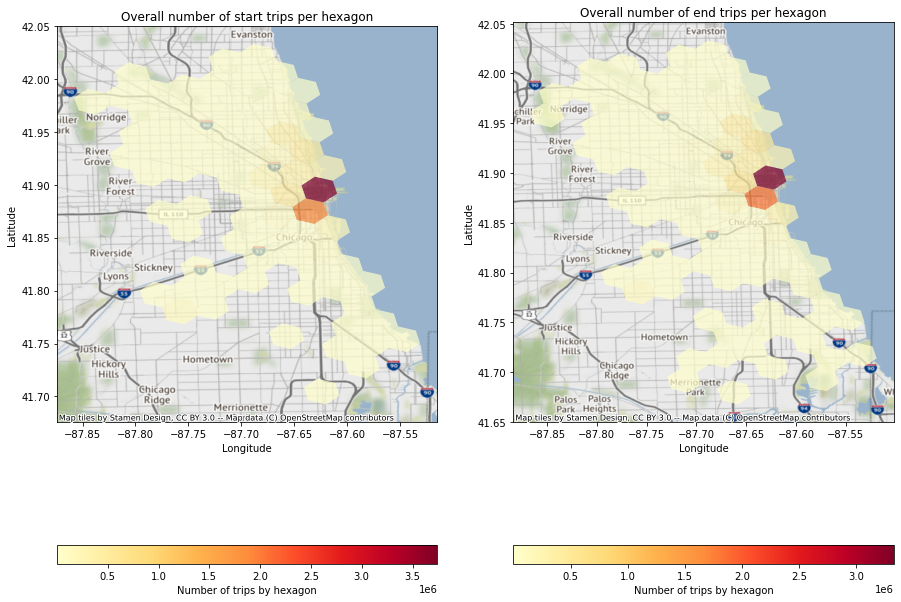

In [8]:
trip_start_vis(trip_data_7)

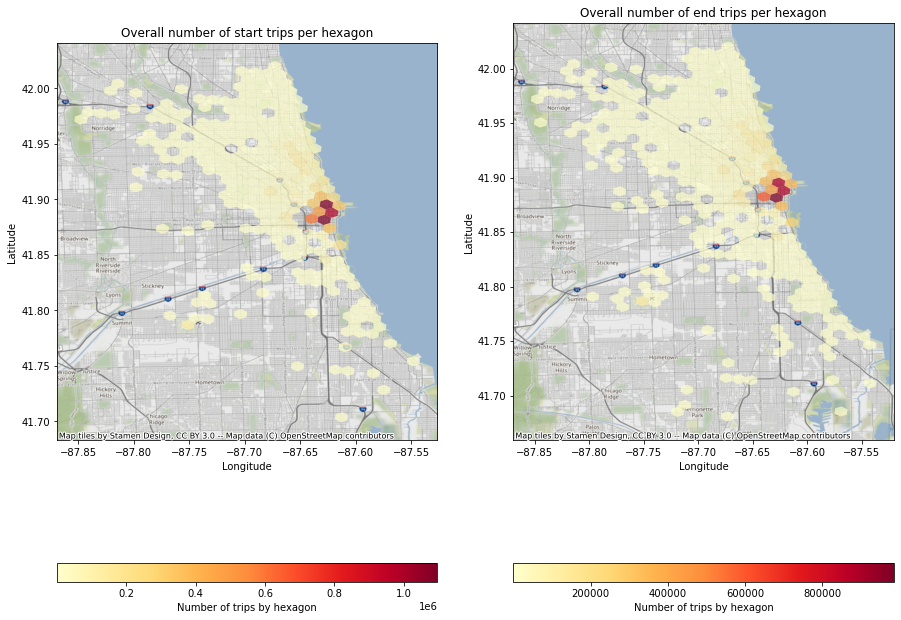

In [9]:
trip_start_vis(trip_data_8)

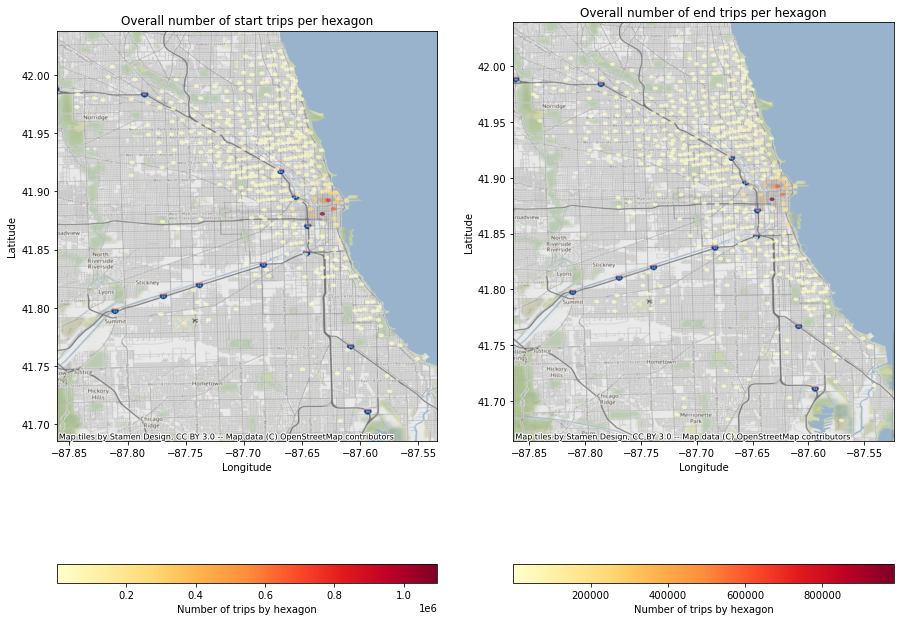

In [10]:
trip_start_vis(trip_data_9)

It is obvious, that Resolution 8 shows the best results in terms of the insights in the distribution. Resolution 7 seems too coarse. Resolution 9 also doesn't lead to further insights, because only the centers of the districts are available in the source data.

Regarding the differences of dropoff and pickup location, no difference is apparent.
There is a clear center of main interest around the Willis Tower and John Hancock Center, two of the highest Skycrapers of Chicago. Furthermore located are different Attractions, like the Grant Park and Maggie Daley Park, the Cloud Gate and the Chicago Architecture Center.
In the other parts of the city the amount of pickups and dropoffs is relatively equal distributed.

Also clearly visible is the high amount of trips to and from the airport, which is located on the top left edge of the map.

In [11]:
start_count_gdf_winter = transform_df_to_gdf(trip_data_8[(trip_data_8['trip_start_timestamp'] >= datetime(2013, 12, 1)) | (trip_data_8['trip_start_timestamp'] <= datetime(2013, 2, 28))].groupby('hex_ID_pickup').agg({'pickup_census_tract': 'count'}, axis=1).rename({'pickup_census_tract': 'num_trips'}, axis=1))
start_count_gdf_spring = transform_df_to_gdf(trip_data_8[(trip_data_8['trip_start_timestamp'] >= datetime(2013, 3, 1)) & (trip_data_8['trip_start_timestamp'] <= datetime(2013, 5, 31))].groupby('hex_ID_pickup').agg({'pickup_census_tract': 'count'}, axis=1).rename({'pickup_census_tract': 'num_trips'}, axis=1))
start_count_gdf_summer = transform_df_to_gdf(trip_data_8[(trip_data_8['trip_start_timestamp'] >= datetime(2013, 6, 1)) & (trip_data_8['trip_start_timestamp'] <= datetime(2013, 8, 31))].groupby('hex_ID_pickup').agg({'pickup_census_tract': 'count'}, axis=1).rename({'pickup_census_tract': 'num_trips'}, axis=1))
start_count_gdf_autmn = transform_df_to_gdf(trip_data_8[(trip_data_8['trip_start_timestamp'] >= datetime(2013, 9, 1)) & (trip_data_8['trip_start_timestamp'] <= datetime(2013, 11, 30))].groupby('hex_ID_pickup').agg({'pickup_census_tract': 'count'}, axis=1).rename({'pickup_census_tract': 'num_trips'}, axis=1))

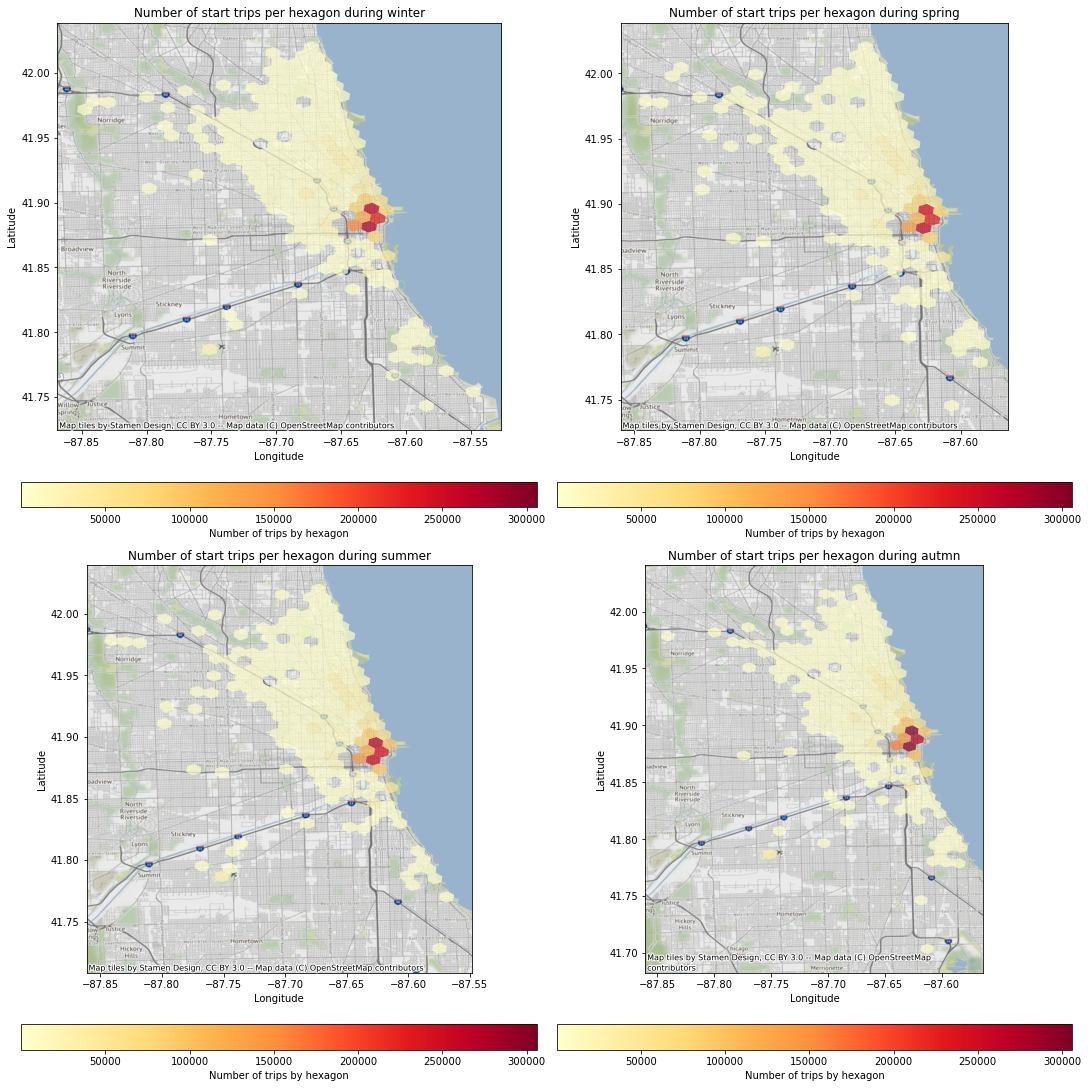

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), constrained_layout=True)
plot_static_choropleth_map(start_count_gdf_winter, ax1[0], 'Number of start trips per hexagon during winter', vmax=start_count_gdf_autmn['num_trips'].max())
plot_static_choropleth_map(start_count_gdf_spring, ax1[1], 'Number of start trips per hexagon during spring', vmax=start_count_gdf_autmn['num_trips'].max())
plot_static_choropleth_map(start_count_gdf_summer, ax2[0], 'Number of start trips per hexagon during summer', vmax=start_count_gdf_autmn['num_trips'].max())
plot_static_choropleth_map(start_count_gdf_autmn, ax2[1], 'Number of start trips per hexagon during autmn', vmax=start_count_gdf_autmn['num_trips'].max())

During the different seasons, there are relatively equal distributed amounts of trips. This is also shown in the visualization below.
All in all in autumn is the highest trip count and maximal number of trips per hexagon - also centered around the New East Side.

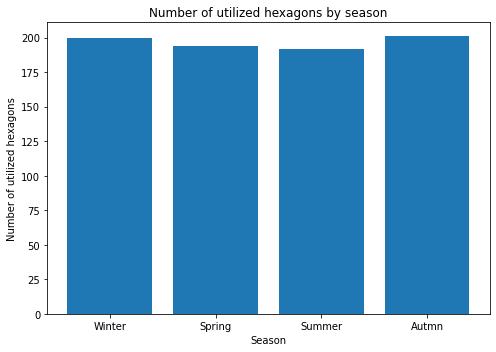

In [13]:
fig, ax = plt.subplots(tight_layout=True, figsize=(7, 5))
ax.bar(x=['Winter', 'Spring', 'Summer', 'Autmn'],
       height=[len(start_count_gdf_winter), len(start_count_gdf_spring), len(start_count_gdf_summer), len(start_count_gdf_autmn)])
ax.set_xlabel('Season')
ax.set_ylabel('Number of utilized hexagons')
ax.set_title('Number of utilized hexagons by season');

Above it another proof, that the utilization of the hexagons is relatively equal, as already shown in the maps.

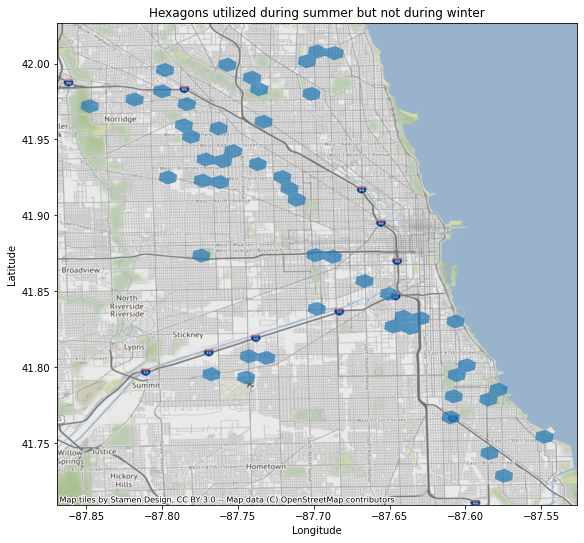

In [14]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
symmetric_difference_gdf = gpd.overlay(start_count_gdf_winter, start_count_gdf_summer, how='symmetric_difference')
plot_static_choropleth_map(symmetric_difference_gdf, ax, 'Hexagons utilized during summer but not during winter', column=None, cmap=None)

This map shows the used heaxgons during summer but not during winter. It can be concluded, that the outer districts don't drive taxi that often in winter due to less traffic within shopping miles or party locations.
Due to the equal distributed amount of trips within the seasons, the traffic inside the center districts around the center of the city must be higher.

Below the net demand gets visualized through after the calculation which is defined as number of ending trips per hexagon substracted by the number of starting trips per hexagon. Negative values mean that there are more trips starting than ending, therefore this could indicate that at this spot more taxis should be placed. Furthermore this means that this would be possibly a good location for a charging station.

In [15]:
start_count_df = trip_data_8.groupby('hex_ID_pickup').agg({'pickup_census_tract': 'count'}, axis=1).rename({'pickup_census_tract': 'num_trips'}, axis=1)
start_count_gdf = transform_df_to_gdf(start_count_df)

end_count_df = trip_data_8.groupby('hex_ID_dropoff').agg({'dropoff_census_tract': 'count'}, axis=1).rename({'dropoff_census_tract': 'num_trips'}, axis=1)
end_count_gdf = transform_df_to_gdf(end_count_df)

In [16]:
net_count_gdf = start_count_gdf.copy()
net_count_gdf['num_trips'] = end_count_gdf['num_trips'] - start_count_gdf['num_trips']
net_count_gdf.dropna(inplace=True, axis=0)

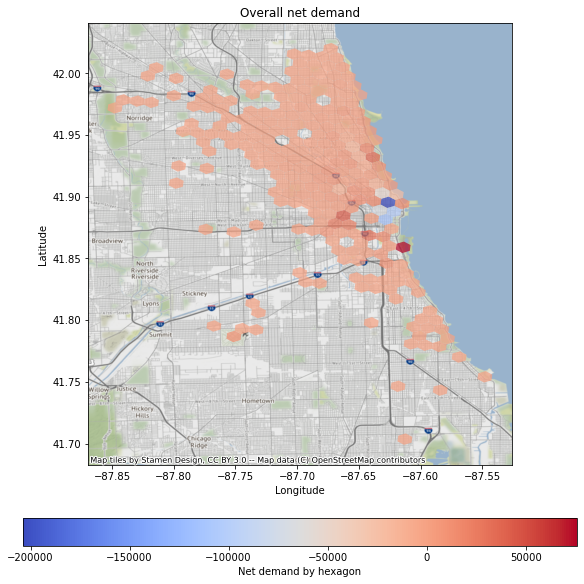

In [17]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
plot_static_choropleth_map(net_count_gdf, ax, title='Overall net demand', cmap='coolwarm', label='Net demand by hexagon')

As assumed, the negative values are located mostly in the center districts of chicago, meanwhile the outer districts shows the opposite. Therefore more people drive from the inside to the outside of the city.

In the following, this patterns get analysed by how the trip patterns divide by morning and afternoon rush hour.

In [18]:
start_count_gdf_morning_rushhour = transform_df_to_gdf(trip_data_8[(trip_data_8['trip_start_timestamp'].dt.hour >= 6) & (trip_data_8['trip_start_timestamp'].dt.hour <= 11)].groupby('hex_ID_pickup').agg({'pickup_census_tract': 'count'}, axis=1).rename({'pickup_census_tract': 'num_trips'}, axis=1))
end_count_gdf_morning_rushhour = transform_df_to_gdf(trip_data_8[(trip_data_8['trip_end_timestamp'].dt.hour >= 6) & (trip_data_8['trip_end_timestamp'].dt.hour <= 11)].groupby('hex_ID_dropoff').agg({'dropoff_census_tract': 'count'}, axis=1).rename({'dropoff_census_tract': 'num_trips'}, axis=1))

start_count_gdf_afternoon_rushhour = transform_df_to_gdf(trip_data_8[(trip_data_8['trip_start_timestamp'].dt.hour >= 15) & (trip_data_8['trip_start_timestamp'].dt.hour <= 20)].groupby('hex_ID_pickup').agg({'pickup_census_tract': 'count'}, axis=1).rename({'pickup_census_tract': 'num_trips'}, axis=1))
end_count_gdf_afternoon_rushhour = transform_df_to_gdf(trip_data_8[(trip_data_8['trip_end_timestamp'].dt.hour >= 15) & (trip_data_8['trip_end_timestamp'].dt.hour <= 20)].groupby('hex_ID_dropoff').agg({'dropoff_census_tract': 'count'}, axis=1).rename({'dropoff_census_tract': 'num_trips'}, axis=1))

In [19]:
net_count_gdf_morning_rushhour  = start_count_gdf_morning_rushhour.copy()
net_count_gdf_morning_rushhour['num_trips'] = end_count_gdf_morning_rushhour['num_trips'] - start_count_gdf_morning_rushhour['num_trips']
net_count_gdf_morning_rushhour.dropna(inplace=True, axis=0)

net_count_gdf_afternoon_rushhour  = start_count_gdf_afternoon_rushhour.copy()
net_count_gdf_afternoon_rushhour['num_trips'] = end_count_gdf_afternoon_rushhour['num_trips'] - start_count_gdf_afternoon_rushhour['num_trips']
net_count_gdf_afternoon_rushhour.dropna(inplace=True, axis=0)

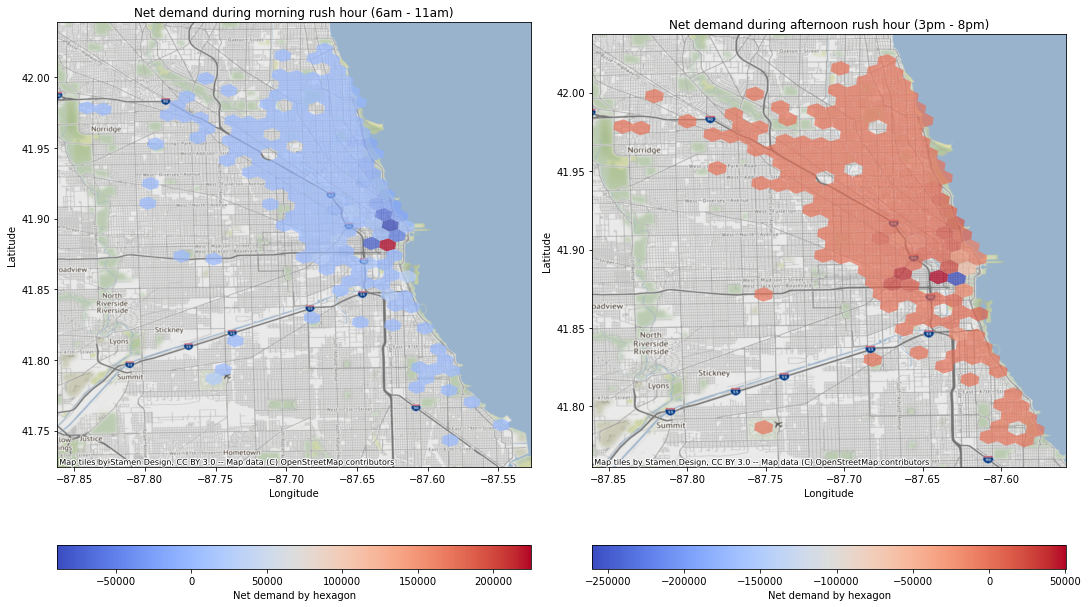

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15), constrained_layout=True)
plot_static_choropleth_map(net_count_gdf_morning_rushhour, ax1, 'Net demand during morning rush hour (6am - 11am)', cmap='coolwarm', label='Net demand by hexagon')
plot_static_choropleth_map(net_count_gdf_afternoon_rushhour, ax2, 'Net demand during afternoon rush hour (3pm - 8pm)', cmap='coolwarm', label='Net demand by hexagon')

As suspected, in the morning hours much more people tend to commute to the inner districts, e.g., to drive to the office, and in the afternoon the opposite phenomen occur.
Due to the fact, that the overall net demand doesn't equal zero, the taxis have to be relocated and therefore the potential bikes have to be reallocated to the inner districs, as the difference of net demand is much higher within the moring hours.